# Modules

In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam

import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# Read Data

In [2]:
data = pd.read_csv("final_dataset.csv")

# Split Data

In [3]:
# split data
xtrain = data[data['split'] == 'train']
ytrain = np.array(xtrain['next_day_excess_return'])
xval = data[data['split'] == 'val']
yval = np.array(xval['next_day_excess_return'])
xtest = data[data['split'] == 'test'].dropna(subset=['next_day_excess_return'])
ytest = np.array(xtest['next_day_excess_return'].dropna())

In [4]:
# drop unnecessary columns and convert to numpy
drop_columns = ['next_day_excess_return','Date','ticker','sector','date','split','adv_dollar']
xtrain = np.array(xtrain.drop(drop_columns, axis=1).dropna(axis=1))
xval = np.array(xval.drop(drop_columns, axis=1).dropna(axis=1))
xtest = np.array(xtest.drop(drop_columns, axis=1).dropna(axis=1))

# drop last row in test to remove na from ytest data
xtest, ytest = xtest[:-1], ytest[:-1]

In [5]:
xtrain.shape, ytrain.shape, xval.shape,yval.shape, xtest.shape,ytest.shape

((237640, 14), (237640,), (99621, 14), (99621,), (99959, 14), (99959,))

# Normalize Data

In [6]:
# calulate normalization
xscaler = MinMaxScaler(feature_range=(0, 1))
xtrain = xscaler.fit_transform(xtrain)

yscaler = MinMaxScaler(feature_range=(0, 1))
ytrain = yscaler.fit_transform(ytrain.reshape(-1, 1))

In [7]:
# normalize validation and test data
xval = xscaler.transform(xval)
yval = yscaler.transform(yval.reshape(-1, 1))
xtest = xscaler.transform(xtest)
ytest = yscaler.transform(ytest.reshape(-1, 1))

# Reshape Data

In [8]:
xtrain = xtrain.reshape(xtrain.shape[0], xtrain.shape[1], 1)
xval = xval.reshape(xval.shape[0], xval.shape[1], 1)
xtest = xtest.reshape(xtest.shape[0], xtest.shape[1], 1)

In [9]:
print(xtrain.shape, ytrain.shape, xval.shape,yval.shape, xtest.shape,ytest.shape)

(237640, 14, 1) (237640, 1) (99621, 14, 1) (99621, 1) (99959, 14, 1) (99959, 1)


# Build Model

In [10]:
from src.models.price_mlp import simple_rnn_price_model
model = simple_rnn_price_model(xtrain[0].shape)

# Train Model

In [11]:
# early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, 
                   restore_best_weights=True)

opt = Adam(learning_rate=0.0001)

In [12]:
# Compile
model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])

# fit network
history = model.fit(xtrain, ytrain, epochs=30, verbose=2, batch_size=64, 
                    validation_data=(xval, yval), callbacks=[es])

Epoch 1/30
3714/3714 - 48s - loss: 0.0031 - accuracy: 4.2080e-06 - val_loss: 4.1926e-04 - val_accuracy: 0.0000e+00 - 48s/epoch - 13ms/step
Epoch 2/30
3714/3714 - 44s - loss: 3.4830e-04 - accuracy: 4.2080e-06 - val_loss: 3.8742e-04 - val_accuracy: 0.0000e+00 - 44s/epoch - 12ms/step
Epoch 3/30
3714/3714 - 44s - loss: 3.4198e-04 - accuracy: 4.2080e-06 - val_loss: 3.8929e-04 - val_accuracy: 0.0000e+00 - 44s/epoch - 12ms/step
Epoch 4/30
3714/3714 - 44s - loss: 3.3386e-04 - accuracy: 4.2080e-06 - val_loss: 3.8375e-04 - val_accuracy: 0.0000e+00 - 44s/epoch - 12ms/step
Epoch 5/30
3714/3714 - 45s - loss: 3.3086e-04 - accuracy: 4.2080e-06 - val_loss: 3.9966e-04 - val_accuracy: 0.0000e+00 - 45s/epoch - 12ms/step
Epoch 6/30
3714/3714 - 46s - loss: 3.2679e-04 - accuracy: 4.2080e-06 - val_loss: 3.7849e-04 - val_accuracy: 0.0000e+00 - 46s/epoch - 12ms/step
Epoch 7/30
3714/3714 - 46s - loss: 3.2138e-04 - accuracy: 4.2080e-06 - val_loss: 3.8292e-04 - val_accuracy: 0.0000e+00 - 46s/epoch - 12ms/step
Epo

# Predict Test Data

In [13]:
predictions = model.predict(xtest)
predictions = yscaler.inverse_transform(predictions)

3124/3124 [==============================] - 10s 3ms/step


# Evaluate Model

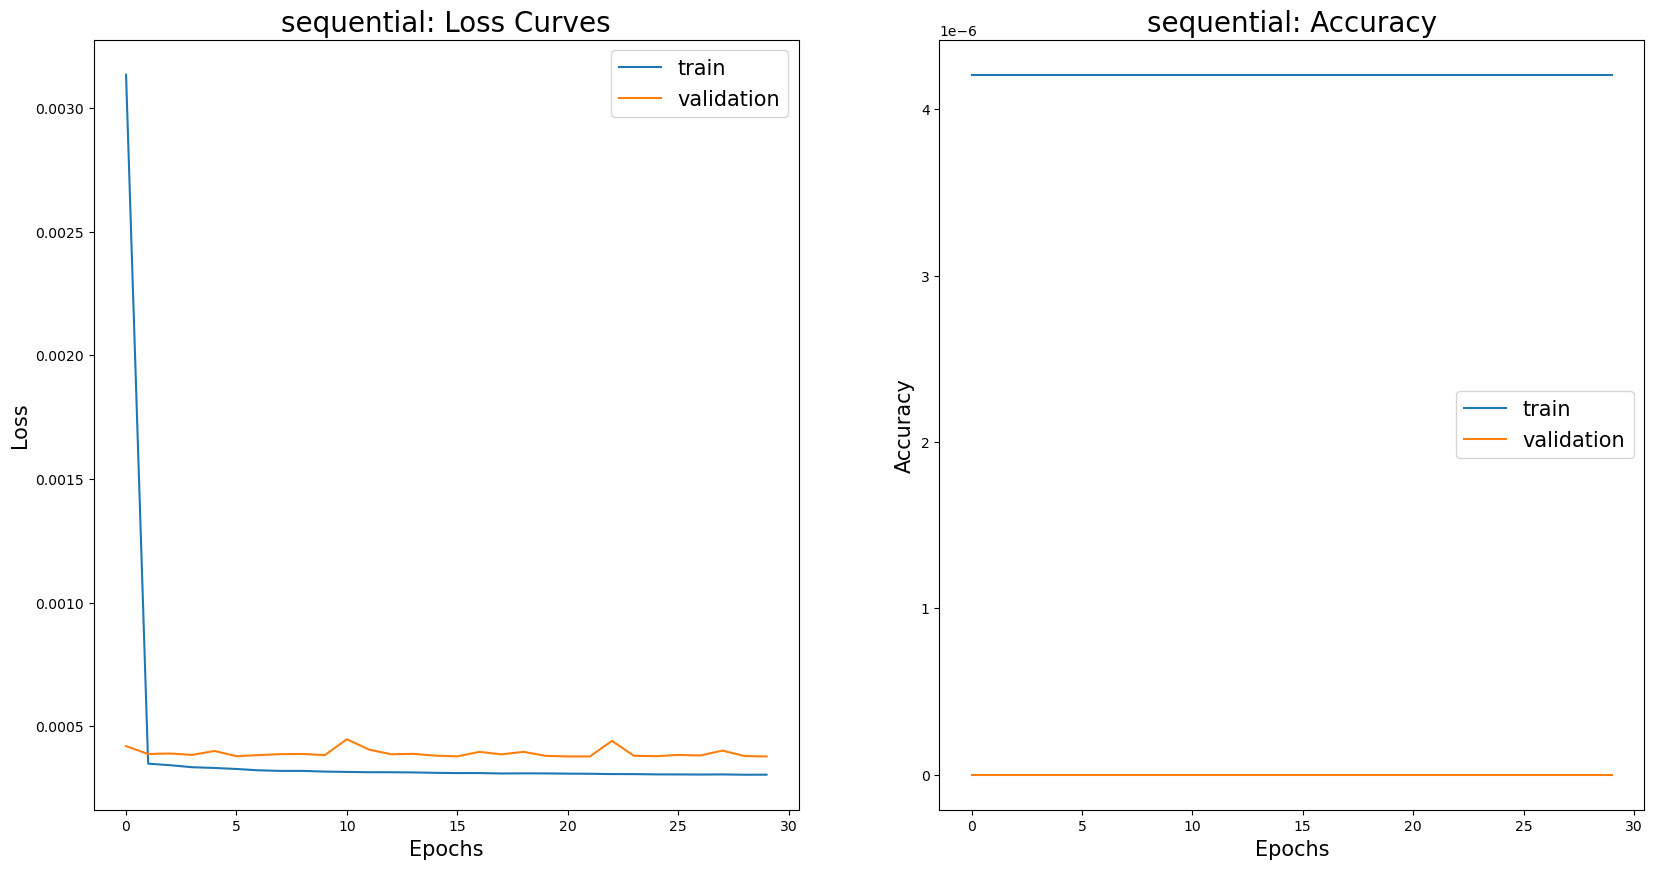

In [14]:
from src.utils.plotting import summarize_price_model_diagnostics
summarize_price_model_diagnostics(model, history)

In [15]:
ytest_unscaled = yscaler.inverse_transform(ytest.reshape(-1, 1))
mse = mean_squared_error(ytest_unscaled, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(ytest_unscaled, predictions)

print(f"Unscaled Mean Squared Error (MSE): {mse}")
print(f"Unscaled Root Mean Squared Error (RMSE): {rmse}")
print(f"Unscaled Mean Absolute Error (MAE): {mae}")

Unscaled Mean Squared Error (MSE): 0.00018992523063283368
Unscaled Root Mean Squared Error (RMSE): 0.013781336315206652
Unscaled Mean Absolute Error (MAE): 0.009229916759595566


In [17]:
# Save the price model 
model.save("/kaggle/working/price_model.keras")